In [113]:
from db_utils import RDSDatabaseConnector, load_credentials
from format import DataFormat
import pandas as pd
from plotter import Plotter
from transform import DataFrameTransform
from db_utils import load_data
from info import DataFrameInfo
import numpy as np

######################################
# Database
# Extract data and save to csv
######################################
# cred_dict = load_credentials()
# rds_con = RDSDatabaseConnector(cred_dict)
# df = rds_con.extract_rds_dataframe('loan_payments')
# RDSDatabaseConnector.save_to_csv(df, "loan_data.csv")
# RDSDatabaseConnector.csv_to_excel('loan_data')

Dataframe Shape: 

(54231, 44)
                             % Null
Unnamed: 0                     0.00
id                             0.00
member_id                      0.00
loan_amount                    0.00
funded_amount                  5.54
funded_amount_inv              0.00
term                           8.80
int_rate                       9.53
instalment                     0.00
grade                          0.00
sub_grade                      0.00
employment_length              3.91
home_ownership                 0.00
annual_inc                     0.00
verification_status            0.00
issue_date                     0.00
loan_status                    0.00
payment_plan                   0.00
purpose                        0.00
dti                            0.00
delinq_2yrs                    0.00
earliest_credit_line           0.00
inq_last_6mths                 0.00
mths_since_last_delinq        57.17
mths_since_last_record        88.60
open_accounts                  0.

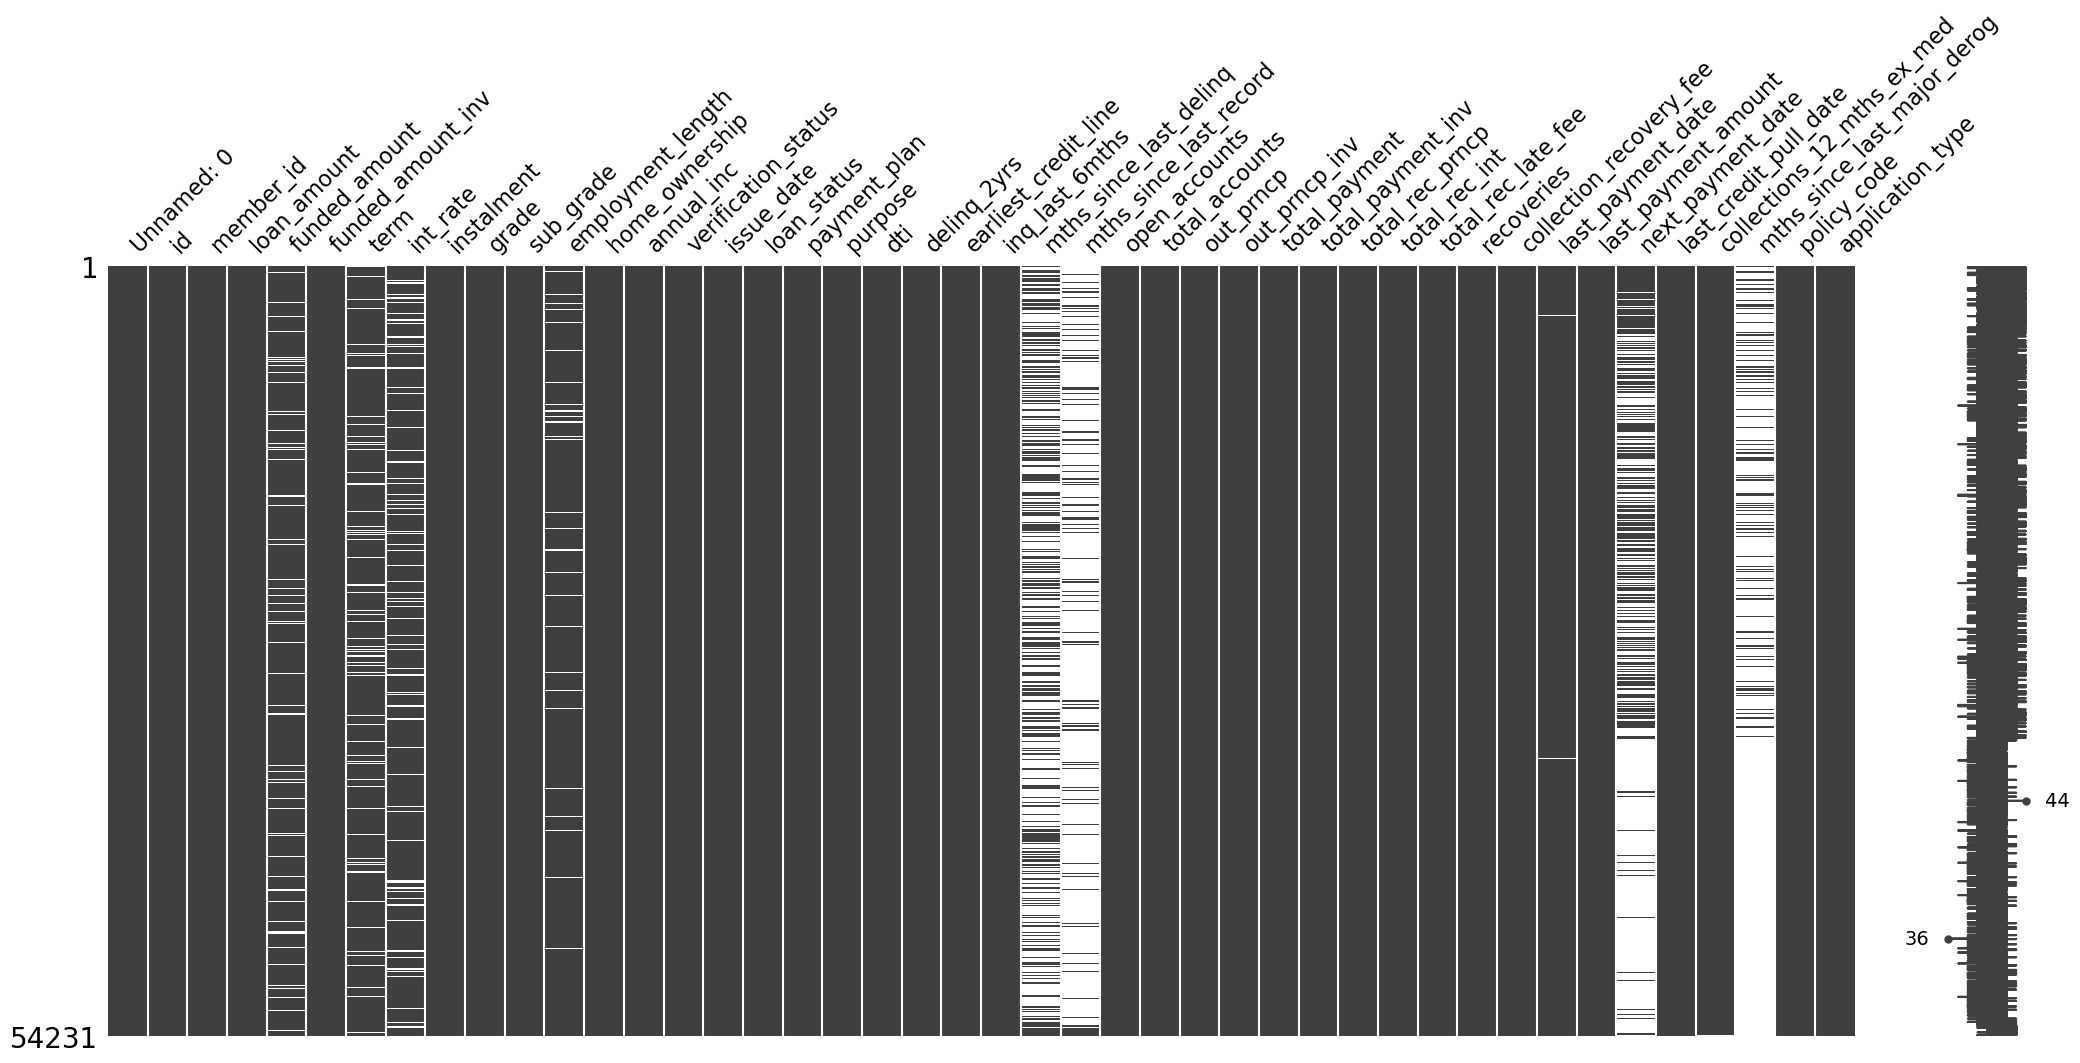

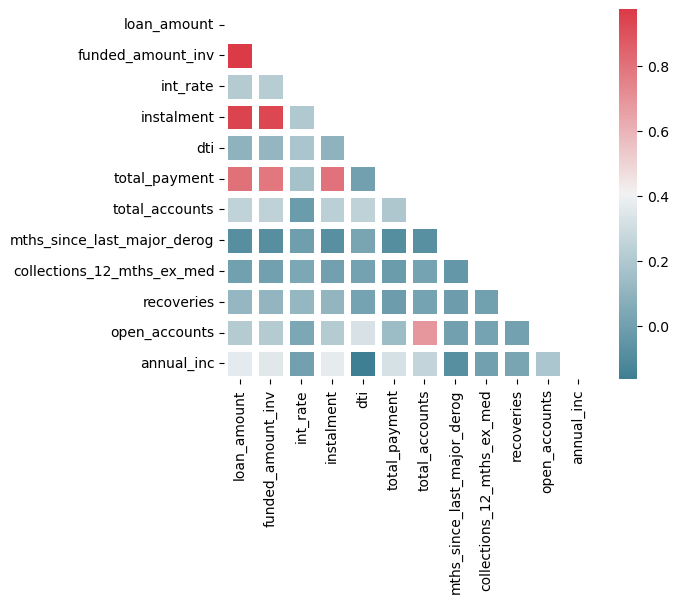

In [114]:
#######################################
# Info
# Understand the dataframe shape, missing percentages and statistics, and missing values
#######################################
df = load_data("/dataset/loan_data.csv")
Info = DataFrameInfo(df)

print(Info.get_shape())
print(Info.percentage_null())
print(Info.describe_columns())
print(Info.extract_statistics(['mths_since_last_major_derog']))

plt = Plotter(df)

numerical_cols = ['loan_amount',
                  'funded_amount_inv', 'int_rate', 'instalment', 'dti', 'total_payment', 'total_accounts', 'mths_since_last_major_derog', 'collections_12_mths_ex_med', 'recoveries', 'open_accounts', 'annual_inc']

plt.missing_nulls_vis()
plt.correlated_vars(numerical_cols)

# MCAR
# 1. mths_since_last_major_derog   86.17 half of the data from vis is MCAR from cutoff point
# 2. sub_grade is MCAR
# 3. term is MCAR because loans must have terms and also its uncorrelated to other nulls missing vals from first look

# NMAR
# 1. inq_last months
# 2. last_payment
# 3. collections_12_mths_ex_med
# 4. employment length
# These values have no entry to signify no record eg. employment length = null because of no employment

###########################################################################
# Term
# Derog is serious delinquency of 30+ days vs delinq = failure to pay on time
###########################################################################

In [115]:
# As we can see there is small correlation between any of the numerical columns
# KNN imputation for missing values wouldn't be optimal because of no multi-variate columns to attatch to

In [116]:
Transformer = DataFormat(df)
# Convert n and y to bool values
Transformer.string_to_boolean('payment_plan')

[ True]


In [117]:
# String dates to date format
string_dates = ['last_credit_pull_date', 'next_payment_date',
                'last_payment_date', 'earliest_credit_line', 'issue_date']

Transformer.strings_to_dates(string_dates)

In [118]:
# Cols to num
string_to_num_cols = ['term', 'employment_length']
numerical_cols = ['term', 'mths_since_last_record',
                  'mths_since_last_major_derog', 'mths_since_last_delinq', 'mths_since_last_record', 'delinq_2yrs']

# Month to intiger
Transformer.extract_num_from_string(string_to_num_cols)
Transformer.numerical_cols(numerical_cols)

# we don't convert these cols : 'mths_since_last_record', 'mths_since_last_major_derog' to int since they include 0 months since last to signify recent entry and null for NO entry
Transformer.to_int(['term', 'open_accounts', 'total_accounts',
                    'collections_12_mths_ex_med', 'delinq_2yrs', 'loan_amount', 'employment_length'])

Transformer.round_float('collection_recovery_fee', 2)

In [119]:
# Before we convert to category columns we manage unique case with NMCAR null values

# Before we convert categories we have to handle unique case of columns:
# mths_since_last_delinq 57.17
# mths_since_last_record 88.60
# mths_since_last_major_derog  86.17

bins = [np.nan, 0, 36, 72, 108, 146]
bin_labels = ['Never', '1-3 Years',
              '4-6 Years', '7-9 Years', '10-12 Years']

bin_cols = ['mths_since_last_delinq', 'mths_since_last_record',
            'mths_since_last_major_derog', 'delinq_2yrs']

for col in bin_cols:
    Transformer.df[col] = pd.cut(Transformer.df[col], bins=bins,
                                 labels=bin_labels, right=True, include_lowest=True)
    Transformer.df[col] = Transformer.df[col].fillna('Never')

categories = ['grade', 'sub_grade', 'home_ownership',
              'verification_status', 'loan_status', 'purpose', 'employment_length']

Transformer.cols_to_categories(categories)
Transformer.cols_to_categories(bin_cols)

# next_payment_date 60.13

In [123]:
# funded_amount seems to have more "nulls" according to .info() meaning that it has missing unexplained values that funded_amount_inv picks up on
# application and policy code have all same values across whole column
# out_prncp_inv/total_payment_inv is the same as out_prncp/total_payment
# next_payment_date doesn't seem useful to us since there are a lot missing (possibly NMAR because suggest payed off loan)

Transformer.df.head()

drop_cols = ['funded_amount', 'application_type',
             'policy_code', 'out_prncp_inv', 'total_payment_inv', 'Unnamed: 0', 'id', 'next_payment_date'
             ]
Transformer.drop_cols(drop_cols)

KeyError: "['funded_amount'] not found in axis"

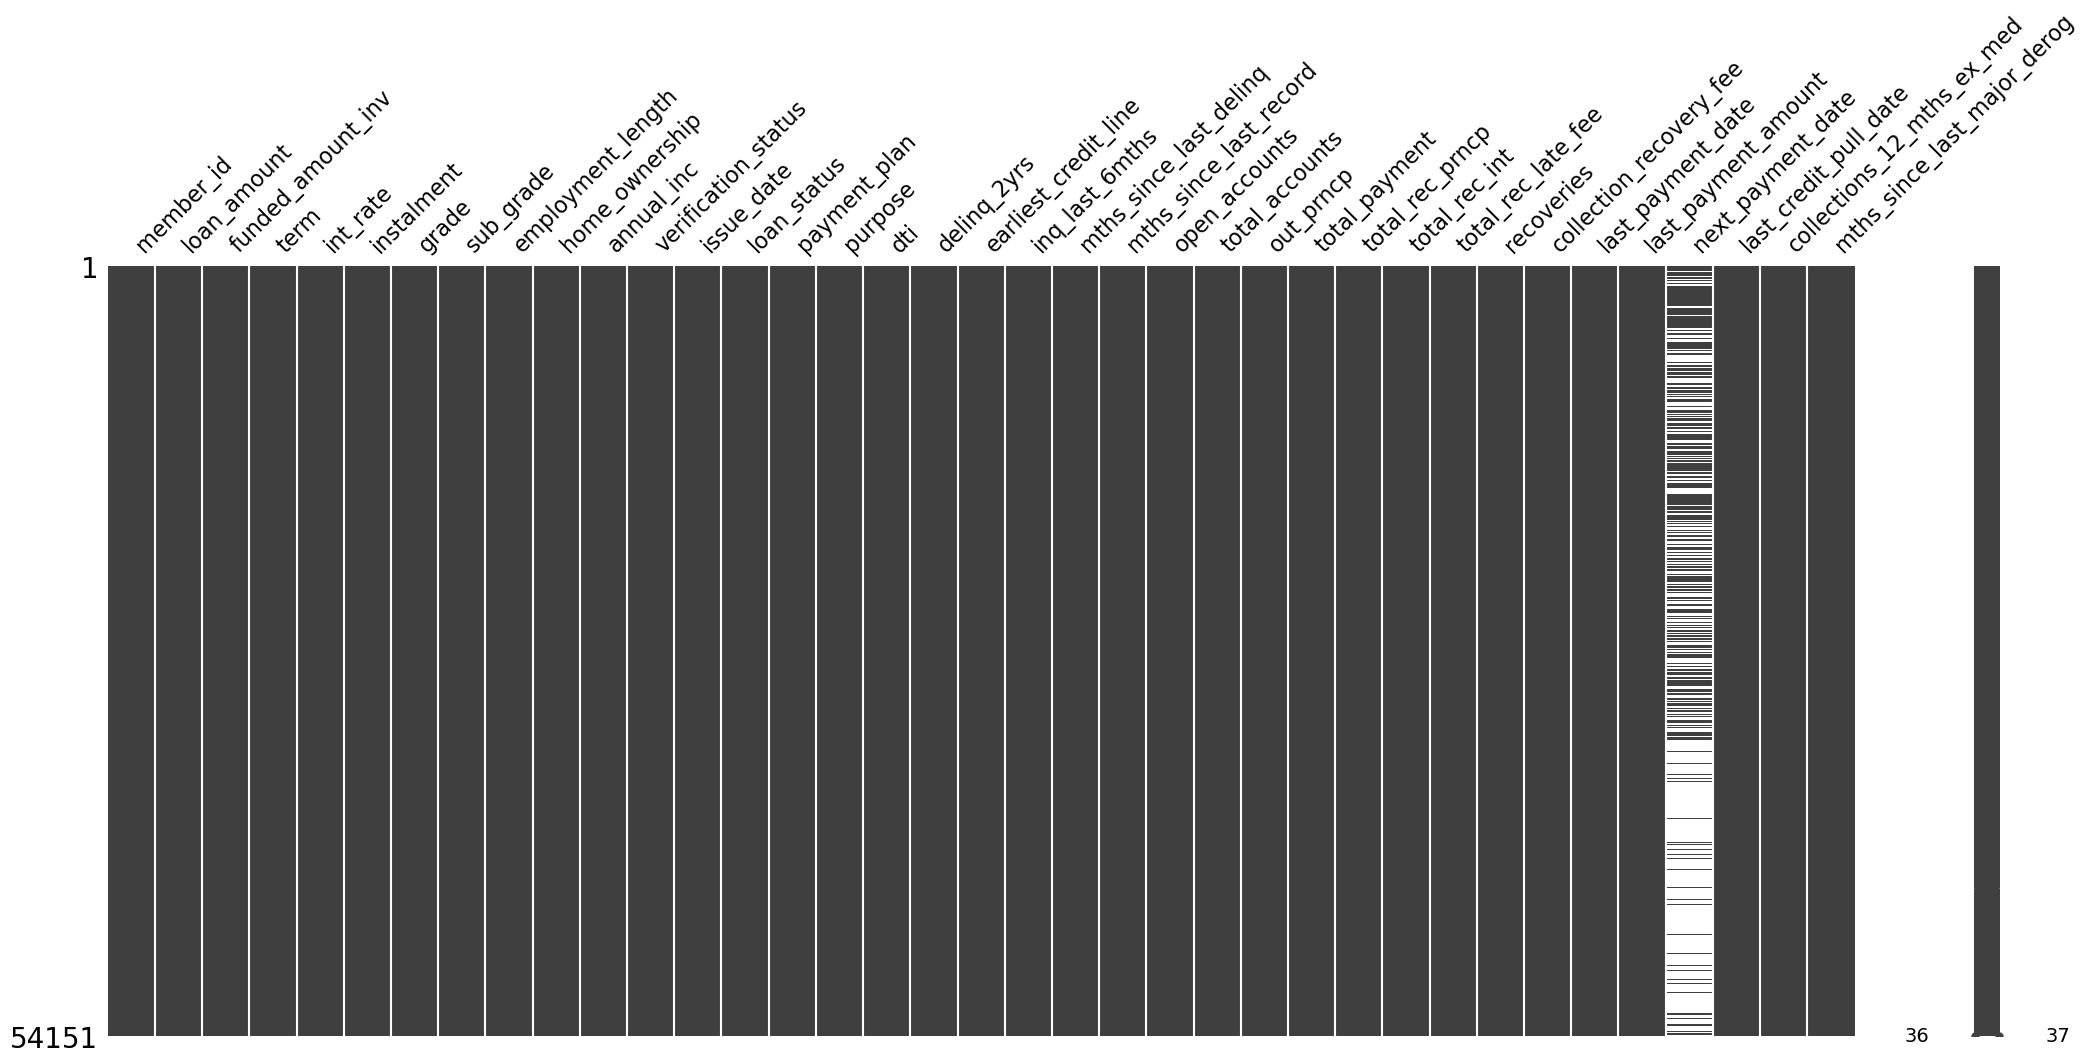

0    1-3 Years
1        Never
2        Never
3        Never
4        Never
Name: mths_since_last_major_derog, dtype: category
Categories (5, object): ['Never' < '1-3 Years' < '4-6 Years' < '7-9 Years' < '10-12 Years']


In [124]:
# Impute and further drop
# NMAR
# missing employment length likely means unemployed so impute 0
df = Transformer.df

t_form = DataFrameTransform(df)

# Assume When Employment length is missing it means they don't have a job
t_form.impute_zeros(['employment_length'])
# mean interest rate since its within normal dist
t_form.impute_median(['int_rate'])

# these rows have insignificant null vals
t_form.drop_null_rows(['last_payment_date', 'last_credit_pull_date'])
plt = Plotter(df)
plt.missing_nulls_vis()
print(df['mths_since_last_major_derog'].head())

c:\Users\prote\miniconda3\envs\eda-proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\prote\miniconda3\envs\eda-proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\prote\miniconda3\envs\eda-proj\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\prote\miniconda3\envs\eda-proj\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Us

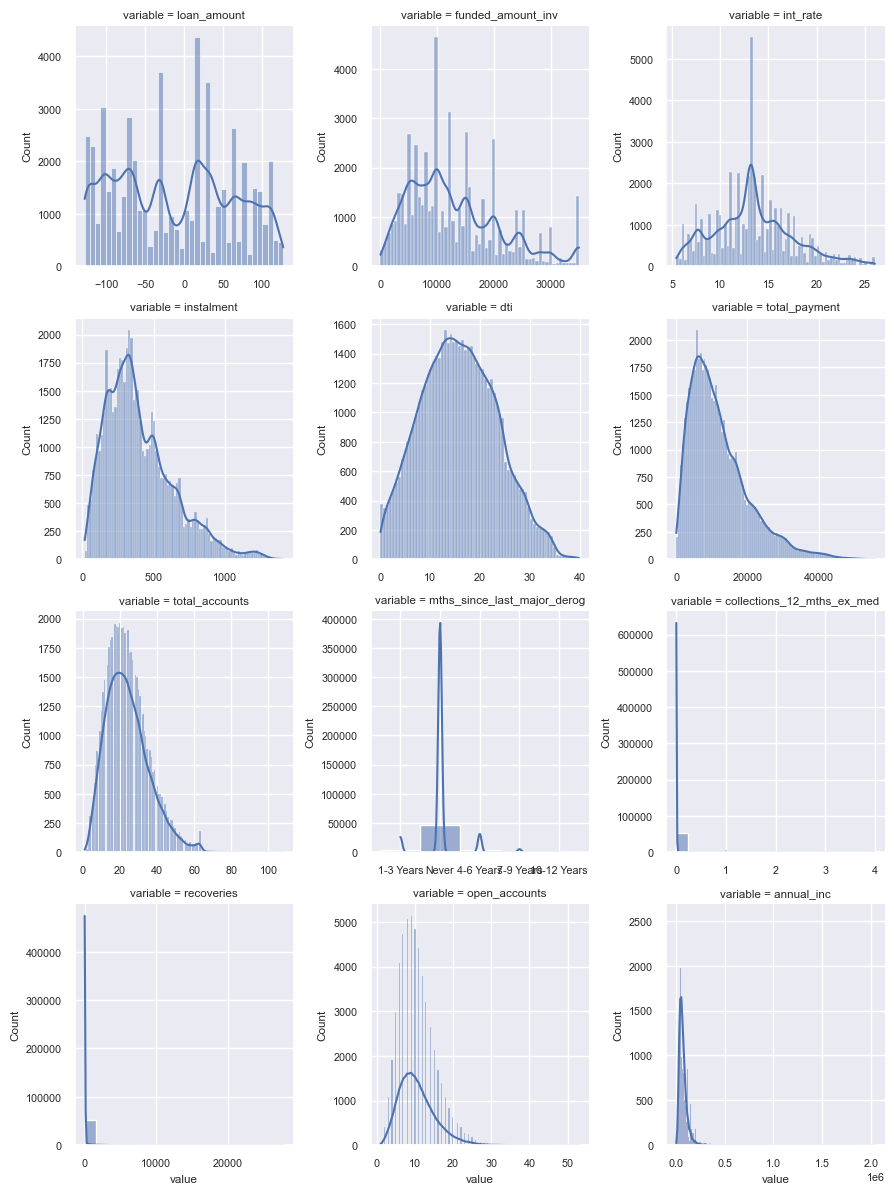

In [125]:

numerical_cols = ['loan_amount',
                  'funded_amount_inv', 'int_rate', 'instalment', 'dti', 'total_payment', 'total_accounts', 'collections_12_mths_ex_med', 'recoveries', 'open_accounts', 'annual_inc']

plt.skewed_cols(numerical_cols)